In [ ]:
%cd /content/
!rm -rf tfde-tfp/
token = input("GitHub token: ")
!git clone https://$token@github.com/simonamtoft/tfde-tfp.git
%cd /content/tfde-tfp

In [2]:
import models as m
import data as d
import utils as utl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tqdm import tqdm

tfn = tf.nn
tfd = tfp.distributions
tfm = tf.math

In [39]:
data = d.gen_2spirals(batch_size=10000)

In [40]:
class TensorTrainGaussian(tf.keras.Model):
    def __init__(self, Ks, seed=None):
        super(TensorTrainGaussian, self).__init__()
        self.Ks = Ks
        self.M = len(Ks) - 1; # [1,1,1] means [k0, k1, k2] -> 2 dimensions
        
        # To produce reproducible results
        if seed != None:
            tf.random.set_seed(seed)

        self.wk0_logits = tf.Variable([[1.]*self.Ks[0]], name='wk0_logits');
        self.W_logits = [
          tf.Variable(
            [ [1.]*self.Ks[i] ]*self.Ks[i+1], # (Ks[i+1], Ks[i])
            name='W{}_logits'.format(i+1)) 
          for i in range(self.M)
        ]

        self.mu = [
          tf.Variable(
            tf.random.uniform([self.Ks[i+1], self.Ks[i]], -5, 5),
            name='mu{}'.format(i+1)
          ) for i in range(self.M)
        ]

        self.pre_sigma = [
          tf.Variable(
            tf.random.uniform([self.Ks[i+1], self.Ks[i]], 0, 5),
            name='sigma{}'.format(i+1)
          ) for i in range(self.M)
        ]

    def call(self, X):
      # z . (A (x) B)^T . (C (x) D)^T ...
      # Ensure that data is (n, M), even if only (M,) is supplied.
      X = tf.cast(tf.reshape(X, (-1, self.M)), tf.float32)

      # Go from logits -> weights
      wk0 = tfn.softmax(self.wk0_logits, axis=1) # axis 1 as it is (1, K0)
      W = [tfn.softmax(self.W_logits[i], axis=0) for i in range(self.M)]
      # Go from raw values -> strictly positive values (ReLU approx.)
      sigma = [tfm.softplus(self.pre_sigma[i]) for i in range(self.M)]

      product = tf.eye(wk0.shape[1]) # start out with identity matrix
      for i in range(self.M):
        result = tfm.exp(
            tfm.log(W[i]) + tfd.Normal(self.mu[i], sigma[i]).log_prob(
                # Make data broadcastable into (n, km, kn)
                X[:, tf.newaxis, tf.newaxis, i]
            )
        ) # intermediary calculation in log-domain -> exp after.
        # Keep batch dimension in place, transpose matrices
        product = product @ tf.transpose(result, perm=[0, 2, 1])
      # In order: Squeeze (n, 1, k_last) -> (n, k_last).
      # Reduce sum over k_last into (n, )
      # Squeeze result to (n, ) if n > 1 or () if n == 1
      likelihoods = tf.squeeze(tf.reduce_sum(tf.squeeze(wk0 @ product, axis=1), axis=1))

      # return both log_prob.
      return tfm.log(likelihoods)#, likelihoods

    def sample(self, N):
      # TO-DO
      # Simply sample from categorical distributions based on wk0 and W logits
      # And then sample from corresponding distributions.
      pass

    @tf.function
    def train_step(self, data, optimizer):
        with tf.GradientTape() as tape:
            log_likelihoods = self(data)
            loss_value = -tf.reduce_mean(log_likelihoods)
    
        # Compute gradients
        tvars = self.trainable_variables
        gradients = tape.gradient(loss_value, tvars)
        optimizer.apply_gradients(zip(gradients, tvars))
        #return loss_value

EPOCHS = 1000
Ks = [10,10,10]
model = TensorTrainGaussian(Ks, 42) # set seed
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [44]:
dataset = d.to_tf_dataset(data, batch_size=64)

losses = []
start_time = time.time()
for epoch in tqdm(range(EPOCHS),desc='Training TT'):    
    loss = 0
    for x in dataset:
        model.train_step(x,optimizer)
    losses.append(-tf.reduce_mean(model(data)).numpy()) 
end_time = time.time()
print(f'Training time elapsed: {int(end_time-start_time)} seconds')
print(f'Final loss: {losses[-1]}')

Training TT: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]

Training time elapsed: 24 seconds
Final loss: 2.9114904403686523


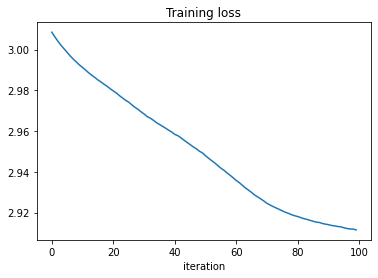

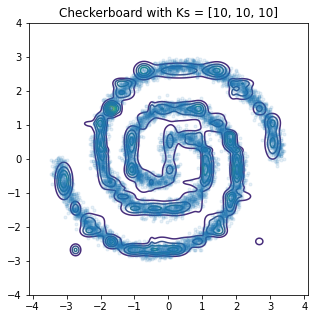

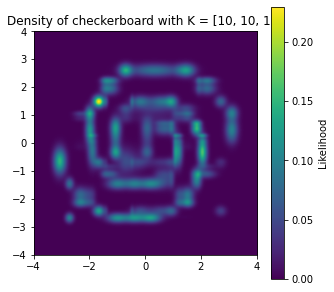

Density integrates to 1.0
It should be = 1.0


In [45]:
f,ax = plt.subplots()
ax.plot(range(len(losses)),np.array(losses))
ax.set_title('Training loss')
ax.set_xlabel('iteration')
plt.show()

#%% Plot result

f,ax = plt.subplots(figsize=(5,5))
utl.plot_contours(ax, data, model,alpha=0.1)
ax.set_title('Checkerboard with Ks = '+str(Ks))
plt.show()
# f.savefig('../figures/TensorTrain/'+name+'_K_'+str(K)+'_contour.png',dpi=300)


f,ax = plt.subplots(figsize=(5,5))
utl.plot_density(ax, model)
ax.set_title('Density of checkerboard with K = '+str(Ks))
plt.show()
# f.savefig('../figures/TensorTrain/'+name+'_K_'+str(K)+'_density.png',dpi=300)

integrand = utl.unitTest(model,limits=[-6,6])
print(f'Density integrates to {round(integrand,4)}')
print('It should be = 1.0')